In [1]:
import cv2

import tensorflow as tf
import os
import random
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.models import Model

from tqdm import tqdm

# from skimage.io import imread, imshow
# from skimage.transform import resize
 
import matplotlib.pyplot as plt

import utils

# from PIL import Image, ImageOps

2022-11-09 02:20:45.191356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2022-10-19 18:31:38.078132: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 18:31:38.078532: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-19 18:31:38.079102: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-19 18:31:38.119605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 18:31:38.119725: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

In [3]:
IMG_WIDTH = 120
IMG_HEIGHT = 120
IMG_CHANNELS = 1

input = layers.Input(((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS)))
normalize = layers.Lambda(lambda x: x/ 255)(input)

## first layer
c1 = layers.Conv2D(16, (3,3), padding='same')(normalize)
b1 = layers.BatchNormalization()(c1)
r1 = layers.ReLU()(b1)
p1 = layers.MaxPooling2D(pool_size=(4,4), strides=(4,4))(r1)

## second layer
c2 = layers.Conv2D(32, (3,3), padding='same')(p1)
b2 = layers.BatchNormalization()(c2)
r2 = layers.ReLU()(b2)
p2 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(r2)

## third layer
c3 = layers.Conv2D(64, (3,3), padding='same')(p2)
b3 = layers.BatchNormalization()(c3)
r3 = layers.ReLU()(b3)
p3 = layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(r3)

## flatten layer
flatten = layers.Flatten()(p3)

## FCLs
fc1 = layers.Dense(256, activation = 'relu')(flatten)
fc2 = layers.Dense(256)(fc1)

model = Model(inputs=input, outputs = fc2)




model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 1)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 120, 120, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 120, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 16)      64        
_________________________________________________________________
re_lu (ReLU)                 (None, 120, 120, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        4640  

2022-10-19 18:32:34.390219: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-19 18:32:34.390481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 18:32:34.390886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 16 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 119.24GiB/s
2022-10-19 18:32:34.391147: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-19 18:32:34.391190: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-19 18:32:34.391214: I tensorflow/stream_executor/platform/

In [19]:
IMG_SIZE = 120

def load_images_from_folder(folder):
    x = []
    y = []
    for filename in tqdm(os.listdir(folder)):
        image = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
        
        _2dh = utils.im2dhist(image, w_neighboring=3)
        
        V_hist = utils.imhist(image)
        CDFx = np.cumsum(np.sum(_2dh, axis=0)) # Kx1

        # normalizes CDFx
        CDFxn = (255*CDFx/CDFx[-1])

        PDFxn = np.zeros_like(CDFxn)
        PDFxn[0] = CDFxn[0]
        PDFxn[1:] = np.diff(CDFxn)

        X_transform = np.zeros((256))
        X_transform[np.where(V_hist > 0)] = PDFxn.copy()
        CDFxn_transform = np.cumsum(X_transform)
        
        
        x.append(image)
        y.append(CDFxn_transform)
            
    return x,y

In [20]:
X,Y = load_images_from_folder('natural_images/')

100%|██████████████████████████████████████████████| 6899/6899 [5:07:19<00:00,  2.67s/it]


In [21]:
x = np.array(X)
y = np.array(Y, np.float64)

In [22]:
x = np.expand_dims(x, axis=3)

In [24]:
#compiling model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [25]:
history = model.fit(x,y, epochs=100)

2022-10-20 00:05:04.658862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-20 00:05:04.678865: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/100


2022-10-20 00:05:05.230734: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-20 00:05:05.455063: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-10-20 00:05:06.432406: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-10-20 00:05:06.474299: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


216/216 [==============================] - 12s 27ms/step - loss: 7037.4511 - accuracy: 0.1443
Epoch 2/100
216/216 [==============================] - 3s 12ms/step - loss: 228.3851 - accuracy: 0.3055
Epoch 3/100
216/216 [==============================] - 3s 12ms/step - loss: 155.1255 - accuracy: 0.3337
Epoch 4/100
216/216 [==============================] - 2s 12ms/step - loss: 125.4316 - accuracy: 0.3422
Epoch 5/100
216/216 [==============================] - 3s 12ms/step - loss: 114.6622 - accuracy: 0.3708
Epoch 6/100
216/216 [==============================] - 3s 12ms/step - loss: 95.7852 - accuracy: 0.3612
Epoch 7/100
216/216 [==============================] - 3s 12ms/step - loss: 96.5532 - accuracy: 0.3360
Epoch 8/100
216/216 [==============================] - 3s 12ms/step - loss: 96.0667 - accuracy: 0.3462
Epoch 9/100
216/216 [==============================] - 3s 12ms/step - loss: 85.8654 - accuracy: 0.3459
Epoch 10/100
216/216 [==============================] - 3s 12ms/step - loss: 8

In [26]:
model.save('./saved_models/model_2dhe')

2022-10-20 00:10:59.285221: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_models/model_2dhe/assets


In [28]:
img = cv2.imread('Plane.jpg',cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img,(120,120))
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img,axis=3)
pred = model.predict(img)[0]

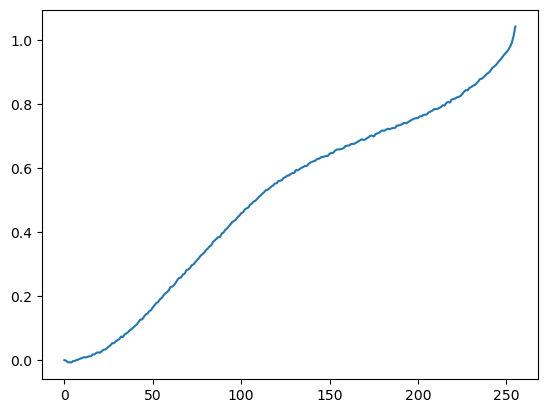

In [30]:
plt.plot(pred/255)